기계학습에서는 오버피팅이 문제가 되는 일이 많다. 오버피팅이란 신경망이 훈련 데이터에만 지나치게 적응되어 그 외의 데이터에는 제대로 대응하지 못하는 상태를 말한다. 기계학습은 범용 성능을 지향한다.

# 6.4.1 오버피팅

오버피팅은 주로 다음의 두 경우에 일어난다. 
- 매개변수가 많고 표현력이 높은 모델
- 훈련 데이터가 적은 모델

이번 절에서는 이 두 요건을 일부러 충족하여 오버피팅을 일으켜보겠다. 그러기 위해 본래 60,000개인 MNIST 데이터셋의 훈련 데이터 중 300개만 사용하고, 7층 네트워크를 사용해 네트워크의 복잡성을 높일것이다. 각 층의 뉴런은 100개, 활성화 함수는 ReLU 함수를 사용한다. 

In [2]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from multilayernet import MultiLayerNet
from optimizer import SGD
from source.dataset.mnist import load_mnist
import matplotlib.pyplot as plt

## 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

x_train = x_train[:300]
t_train = t_train[:300]

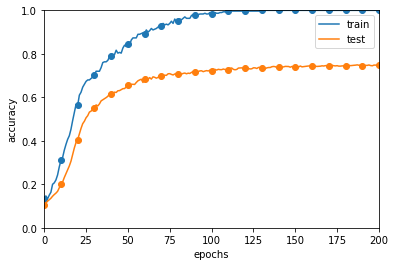

In [12]:
network = MultiLayerNet(input_size=784, hidden_size=[100,100,100,100,100,100], output_size=10, weight_init="ReLU")
optimizer = SGD(lr=0.01)

iters_num = 10000
max_epochs = 201

train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if (i % iter_per_epoch) == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break
            
epochs = np.arange(epoch_cnt)

plt.plot(epochs, train_acc_list, label="train")
plt.plot(epochs, test_acc_list, label="test")
plt.scatter(epochs[::10], train_acc_list[::10])
plt.scatter(epochs[::10], test_acc_list[::10])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0,200)
plt.ylim(0.0,1.0)
plt.legend()
plt.show()

<img src=images/6_20.png height=100px width=500px>

훈련 데이터를 사용하여 측정한 정확도는 100 에폭을 지나는 무렵부터 거의 100% 이다. 그러나 시험 데이터에 대해서는 큰 차이를 보인다. 이처럼 정확도가 크게 벌어지는 것은 훈련 데이터에만 적응(fitting)해버린 결과이다. 훈련 때 사용하지 않은 범용 데이터에는 제대로 대응하지 못하는 것을 이 그래프에서 확인할 수 있다.

# 6.4.2 가중치 감소

오버피팅 억제용으로 예로부터 많이 사용해온 방법 중 "__가중치 감소(weight decay)__"라는 것이 있다. 이는 학습 과정에서 큰 가중치에 대해서는 그에 상응하는 큰 페널티를 부과하여 오버피팅을 억제하는 방법이다. 원래 오버피팅은 가중치 매개변수의 값이 커서 발생하는 경우가 많기 때문이다. 

신경망 학습의 목적은 손실 함수의 값을 줄이는 것이다. 이때, 예를 들어 가중치의 제곱 놈(norm)을 손실 함수에 더한다. 그러면 가중치가 커지는 것을 억제할 수 있다. 가중치를 W라 하면 L2 놈에 따른 가중치 감소는 $\frac{1}{2}\lambda W^2$이 되고, 이 $\frac{1}{2}\lambda W^2$을 손실 함수에 더한다. 여기서 $\lambda$는 정규화의 세기를 조절하는 하이퍼파라미터이다. $\lambda$를 크게 설정할수록 큰 가중치에 대한 페널티가 커진다. 또 $\frac{1}{2}\lambda W^2$의 앞쪽 $\frac{1}{2}$는 $\frac{1}{2}\lambda W^2$의 미분 결과인 $\lambda W$를 조정하는 역할의 상수이다. 가중치 감소는 모든 가중치 각각의 손실 함수에 $\frac{1}{2}\lambda W^2$를 더한다. 따라서 가중치의 기울기를 구하는 계산에서는 그 동안의 오차역전파법에 따른 결과에 정규화 항을 미분한 $\lambda W$를 더한다. 

이를 적용해 실행해보면, 다음과 같다.

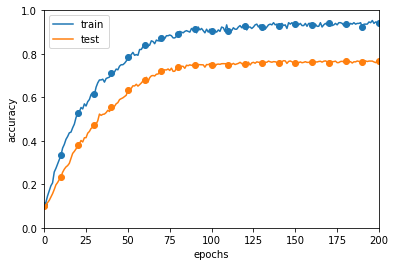

In [11]:
network = MultiLayerNet(input_size=784, hidden_size=[100,100,100,100,100,100], output_size=10, weight_init="ReLU", wd_lambda=0.1)
optimizer = SGD(lr=0.01)

iters_num = 10000
max_epochs = 201

train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if (i % iter_per_epoch) == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break
            
epochs = np.arange(epoch_cnt)

plt.plot(epochs, train_acc_list, label="train")
plt.plot(epochs, test_acc_list, label="test")
plt.scatter(epochs[::10], train_acc_list[::10])
plt.scatter(epochs[::10], test_acc_list[::10])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0,200)
plt.ylim(0.0,1.0)
plt.legend()
plt.show()

<img src=images/6_21.png height=100px widht=500px>

이와 같이 훈련 데이터에 대한 정확도와 시험 데이터에 대한 정확도에는 여전히 차이가 있지만, 가중치 감소를 이용하지 않은 위의 결과와 비교하면 그 차이가 줄었다. 다시 말해 오버피팅이 억제 되었다는 소리이다. 그리고 앞서와 달리 훈련 데이터에 대한 정확도가 100%에 도달하지 못한 점도 주목해야 한다.

# 6.4.3 드롭아웃

앞 절에서는 오버피팅을 억제하는 방식으로 손실 함수에 가중치의 L2 놈을 더한 가중치 감소 방법을 설명하였다. 가중치 감소는 간단하게 구현할 수 있고, 어느 정도 지나친 학습을 억제할 수 있다. 그러나 신경망 모델이 복잡해지면 가중치 감소만으로는 대응하기 어려워진다. 이럴 때는 흔히 "__드롭아웃(Dropout)__"이라는 기법을 이용한다.

드롭아웃은 뉴런을 임의로 삭제하면서 학습하는 방법이다. 훈련 때 은닉층의 뉴런을 무작위로 골라 삭제한다. 삭제된 뉴런은 다음과 같이 신호를 전달하지 않게 된다. 훈련 때는 데이터를 흘릴때마다 삭제할 뉴런을 무작위로 선택하고, 시험 때는 모든 뉴런에 신호를 전달한다. 단, 시험 때는 각 뉴런의 출력에 훈련 때 삭제 안 한 비율을 곱하여 출력한다.

<img src=images/6_22.png height=100px width=500px>

이제 드롭아웃을 구현할 차례이다. 다음 코드는 이해하기 쉽도록 구현한 것이다. 순전파를 담당하는 forward 메소드에서는 훈련 때 (train_flg = True)만 잘 계산해두면 시험 때는 단순히 데이터를 흘리기만 하면 된다. 삭제 안 한 비율은 곱하지 않아도 좋다. 실제 딥러닝 프레임워크들도 비율을 곱하지 않는다.

In [13]:
class DropoutLayer:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        
        else:
            return x * (1.0 - self.dropout_ratio)
    
    def backward(self, dout):
        return dout * self.mask

이 실험은 마찬가지로 7층 네트워크(각 층의 뉴런 수는 100개, 활성화 함수는 ReLU 함수)를 사용하여 진행하였다. 결과는 다음과 같다.

<img src=images/6_23.png height=100px width=500px>

그림과 같이 드롭아웃을 적용하니 훈련 데이터와 시험 데이터에 대한 정확도 차이가 줄었다. 또, 훈련 데이터에 대한 정확도가 100%에 도달하지도 않게 되었다. 이처럼 드롭아웃을 이용하면 표현력을 높이면서도 오버피팅을 억제할 수 있다.